In [39]:
import cv2
import numpy as np

draw = False
window_name = "Paint Goal Mask"

# Dimensions of the image
img_rows, img_cols = 224, 224

def nothing(x):
    pass

def draw_circle(event, x, y, flags, param):
    global draw, img

    if event == cv2.EVENT_LBUTTONDOWN:
        draw = True

    elif event == cv2.EVENT_MOUSEMOVE:
        if draw:
            cv2.circle(img, (x,y), cv2.getTrackbarPos("Brush Size", window_name),
                       (255,255,255),
                       -1)

    elif event==cv2.EVENT_LBUTTONUP:
        draw = False
        cv2.circle(img, (x,y), cv2.getTrackbarPos("Brush Size", window_name),
                       (255,255,255),
                       -1)

In [40]:
# Goal Mask
cv2.namedWindow(window_name)
cv2.createTrackbar("Brush Size", window_name, 1, 8, nothing)
cv2.setMouseCallback(window_name, draw_circle)
img = np.zeros((img_rows, img_cols,1), np.uint8)
while(1):
    cv2.imshow(window_name, img)
    key = cv2.waitKey(1) & 0xff
    if key==ord('q'):
        goal_img = img # save the goal mask img
        break
cv2.destroyAllWindows()
goal_coords_list = np.argwhere(goal_img == 255)[:,0:2]

In [41]:
# Obstacle Mask
cv2.namedWindow(window_name)
cv2.createTrackbar("Brush Size", window_name, 1, 8, nothing)
cv2.setMouseCallback(window_name, draw_circle)
img = np.zeros((img_rows, img_cols,1), np.uint8)
while(1):
    cv2.imshow(window_name, img)
    key = cv2.waitKey(1) & 0xff
    if key==ord('q'):
        obstacle_img = img # save the goal mask img
        break
cv2.destroyAllWindows()
obstacle_coords_list = np.argwhere(obstacle_img == 255)[:,0:2]

/tmp/ipykernel_17061/1732947359.py:25: RuntimeWarning: divide by zero encountered in log
  obstacle_list =  50*(-np.log(np.amin(spatial.distance.cdist(pixel_list,obstacle_coords_list),axis=1))+np.log(safe_margin))


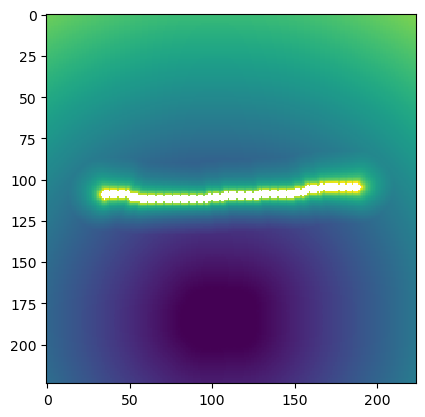

In [4]:
import numpy as np
from matplotlib.pyplot import imshow
import scipy
from scipy import spatial
import time
import matplotlib.pyplot as plt

# Dimensions of the image
img_rows, img_cols = 224, 224

# Create grids of row and column indices
rows, cols = np.meshgrid(np.arange(img_rows), np.arange(img_cols), indexing='ij')

# Combine the row and column grids into a single array
pixel_list = np.array([rows.flatten(), cols.flatten()], dtype=int).T
        
pixel_coords= pixel_list.reshape(img_rows,img_cols,2)
        
goal_list = np.amin(spatial.distance.cdist(pixel_list,goal_coords_list),axis=1)



# Log potential
safe_margin = 20
obstacle_list =  50*(-np.log(np.amin(spatial.distance.cdist(pixel_list,obstacle_coords_list),axis=1))+np.log(safe_margin))
obstacle_list[obstacle_list<0] = 0

# # 1/x 
# obstacle_list =  5e2/(np.amin(spatial.distance.cdist(pixel_list,obstacle_coords_list),axis=1))


potential_list =  obstacle_list + goal_list
# Reshape 
potential_field = potential_list.reshape(img_rows,img_cols)
plt.imshow(potential_field)

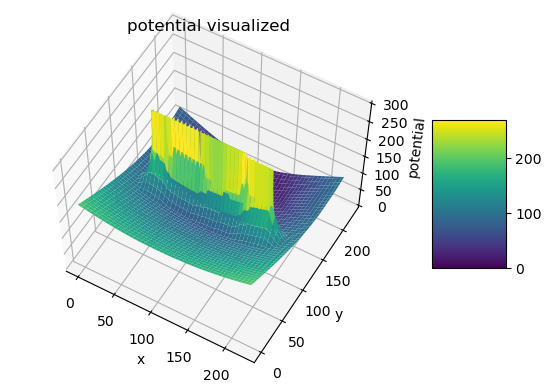

In [7]:
from mpl_toolkits import mplot3d

x = np.linspace(0, 223, 224)
y = np.linspace(0, 223, 224)
X, Y = np.meshgrid(x, y)
Z = potential_field
Z[np.isinf(Z)] = 3e2

fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
fig.colorbar(surf, shrink=0.4, aspect=2)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('potential')
ax.set_title('potential visualized')
ax.view_init(60, -60)
plt.show()


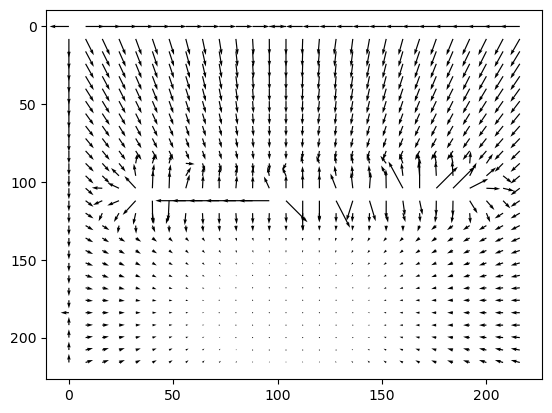

In [13]:
step = 8

# Calculate the gradient in the x and ydirection
img = potential_field
sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

# # Using original Sobel grad
# x_flow, y_flow = sobelx, sobely

# Modified by dist
theta = np.arctan2(sobely,sobelx)
x_flow = np.multiply(potential_field,np.cos(theta))
y_flow = np.multiply(potential_field,np.sin(theta))

# # Modified by dist and discretized
# def find_closest(val,arr):
#            idx = np.abs(arr - (val%(2*np.pi))).argmin()
#            return idx, arr[idx]
        
# rot_num = 16

# discret_theta_array = np.linspace(0,2*np.pi-(np.pi/8),rot_num)

# # Modified by dist and discretized
# theta_org = np.arctan2(sobely,sobelx)
# theta_discret_idx = np.zeros((np.size(theta_org,0),np.size(theta_org,1)))
# theta_discret_val = np.zeros((np.size(theta_org,0),np.size(theta_org,1)))

# for (x,y), value in np.ndenumerate(theta_org):
#            theta_discret_idx[x,y],theta_discret_val[x,y] = find_closest(value,discret_theta_array)

# x_flow = np.multiply(potential_field,np.cos(theta_discret_val))
# y_flow = np.multiply(potential_field,np.sin(theta_discret_val))
 

# Plot the gradient field
plt.quiver(pixel_coords[:,:,1][::step,::step],pixel_coords[:,:,0][::step,::step],-x_flow[::step,::step], y_flow[::step,::step])
# plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

In [22]:
theta.shape

(224, 224)

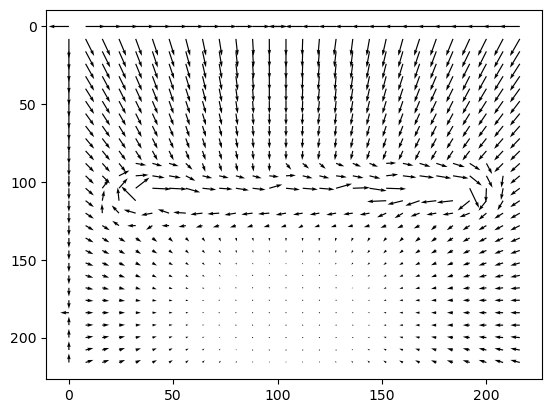

In [14]:
# Reshape 
obstacle_field = obstacle_list.reshape(img_rows,img_cols)
goal_field = goal_list.reshape(img_rows,img_cols)

# Calculate the gradient in the x,y direction
img = obstacle_field
obs_sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
obs_sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

# Calculate the gradient in the x,y direction
img = goal_field
goal_sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
goal_sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)



step = 8

sobelx =  goal_sobelx - obs_sobely
sobely =  goal_sobely + obs_sobelx

# # Using original Sobel grad
# x_flow, y_flow = sobelx, sobely

# Modified by dist
theta = np.arctan2(sobely,sobelx)
x_flow = np.multiply(potential_field,np.cos(theta))
y_flow = np.multiply(potential_field,np.sin(theta))

# # Modified by dist and discretized
# def find_closest(val,arr):
#            idx = np.abs(arr - (val%(2*np.pi))).argmin()
#            return idx, arr[idx]
        
# rot_num = 16

# discret_theta_array = np.linspace(0,2*np.pi-(np.pi/8),rot_num)

# # Modified by dist and discretized
# theta_org = np.arctan2(sobely,sobelx)
# theta_discret_idx = np.zeros((np.size(theta_org,0),np.size(theta_org,1)))
# theta_discret_val = np.zeros((np.size(theta_org,0),np.size(theta_org,1)))

# for (x,y), value in np.ndenumerate(theta_org):
#            theta_discret_idx[x,y],theta_discret_val[x,y] = find_closest(value,discret_theta_array)

# x_flow = np.multiply(potential_field,np.cos(theta_discret_val))
# y_flow = np.multiply(potential_field,np.sin(theta_discret_val))


# Plot the gradient field
plt.quiver(pixel_coords[:,:,1][::step,::step],pixel_coords[:,:,0][::step,::step],-x_flow[::step,::step], y_flow[::step,::step])
# plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

0.0030214786529541016


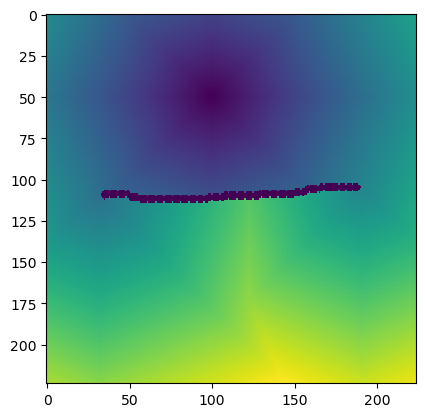

In [15]:
import spfa
import time 
# Create test map
num_rows = img_rows
num_cols = img_cols
source_i = 50
source_j = 100
source = (source_i, source_j)
free_space_map = np.ones([num_rows, num_cols], dtype=bool)
obs_mask = obstacle_img[:,:,0]
free_space_map[obs_mask>0] = False

# Run SPFA
st = time.time()
dists, parents = spfa.spfa(free_space_map, source)
et = time.time()
print((et-st))
plt.imshow(dists)

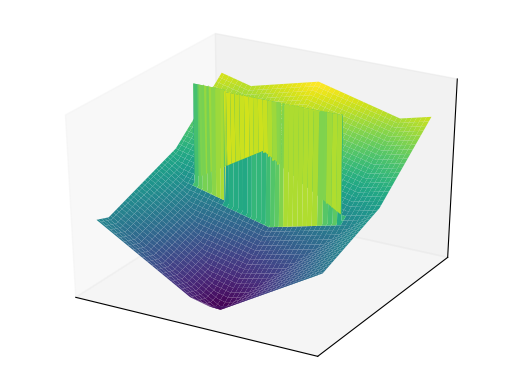

In [38]:
from mpl_toolkits import mplot3d

x = np.linspace(0, 223, 224)
y = np.linspace(0, 223, 224)
X, Y = np.meshgrid(x, y)
Z = dists
Z[np.isinf(Z)] = 3e2
Z[obs_mask>0] = 300

fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# fig.colorbar(surf, shrink=0.4, aspect=2)

# ax.set_xlabel('x')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# ax.set_ylabel('y')
# ax.set_zlabel('wavefront potential')
# ax.set_title('wavefront potential visualized')
ax.view_init(30, 120)
plt.show()


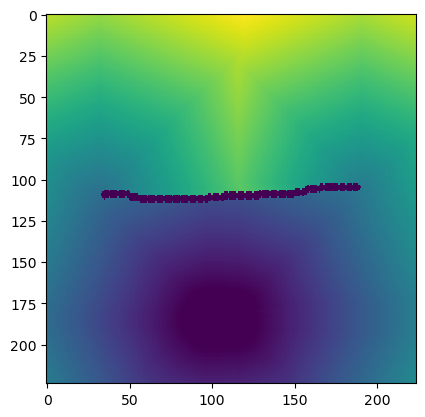

In [18]:
len_goal = len(goal_coords_list)
sfpa_cdist = np.zeros((img_rows*img_cols,len_goal))
for index in np.arange(len_goal):
    dists, _ = spfa.spfa(free_space_map, goal_coords_list[index])
    sfpa_cdist[:,index] = dists.reshape(img_rows*img_cols)
sfpa_list = np.amin(sfpa_cdist,axis=1)
sfpa_potential_field = sfpa_list.reshape(img_rows,img_cols)
plt.imshow(sfpa_potential_field)

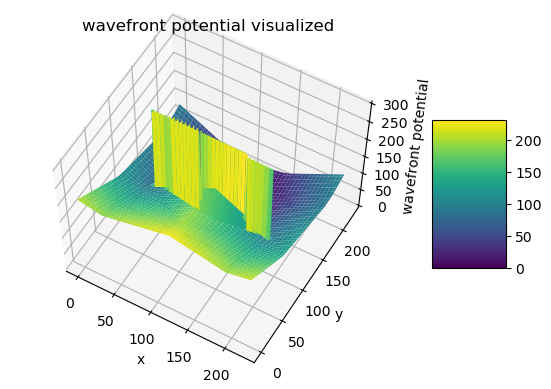

In [19]:
from mpl_toolkits import mplot3d
x = np.linspace(0, 223, 224)
y = np.linspace(0, 223, 224)
X, Y = np.meshgrid(x, y)
Z = sfpa_potential_field
Z[np.isinf(Z)] = 3e2
Z[obs_mask>0] = 300

fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
fig.colorbar(surf, shrink=0.4, aspect=2)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('wavefront potential')
ax.set_title('wavefront potential visualized')
ax.view_init(60, -60)
plt.show()

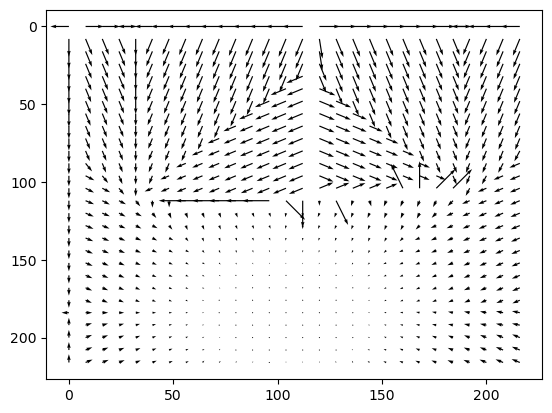

In [26]:
# Calculate the gradient in the x direction
img = sfpa_potential_field
sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
sobel_grad = np.dstack((sobelx,sobely))

# Modified by dist
theta = np.arctan2(sobely,sobelx)
x_flow = np.multiply(sfpa_potential_field,np.cos(theta))
y_flow = np.multiply(sfpa_potential_field,np.sin(theta))

# Plot the gradient field
plt.quiver(pixel_coords[:,:,1][::step,::step],pixel_coords[:,:,0][::step,::step],-x_flow[::step,::step], y_flow[::step,::step])
# plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

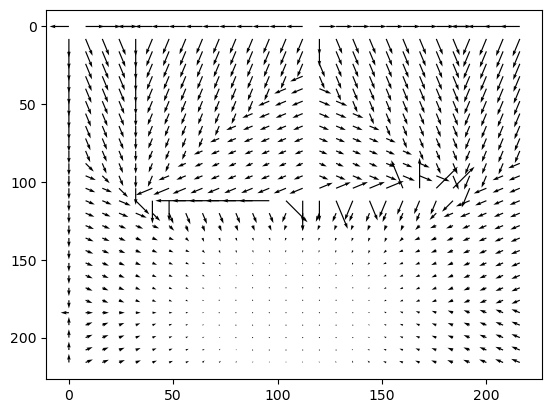

In [27]:
# Modified by dist and discretized
def find_closest(val,arr):
           idx = np.abs(arr - (val%(2*np.pi))).argmin()
           return idx, arr[idx]
        
rot_num = 16

discret_theta_array = np.linspace(0,2*np.pi-(np.pi/8),rot_num)

# Modified by dist and discretized
theta_org = np.arctan2(sobely,sobelx)
theta_discret_idx = np.zeros((np.size(theta_org,0),np.size(theta_org,1)))
theta_discret_val = np.zeros((np.size(theta_org,0),np.size(theta_org,1)))

for (x,y), value in np.ndenumerate(theta_org):
           theta_discret_idx[x,y],theta_discret_val[x,y] = find_closest(value,discret_theta_array)

x_flow = np.multiply(potential_field,np.cos(theta_discret_val))
y_flow = np.multiply(potential_field,np.sin(theta_discret_val))

# Plot the gradient field
plt.quiver(pixel_coords[:,:,1][::step,::step],pixel_coords[:,:,0][::step,::step],-x_flow[::step,::step], y_flow[::step,::step])
# plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()